# Amazon Product Analysis from SmartScout

In this project, we want to transform large csvs of data about Amazon, and create a multimodal artificial intelligence that will give the user a prediction of how successful the product will be. We want to use a K-Nearest-Neighbors Classifier to score the attractiveness of the product's title image given the surrounding images' attractiveness, given by their sales. We want to use a Natural Language Processing Model to score how well the product's title and description are (So, there will be two NLP models). Finally, we want to create a neural network that takes in those scores as inputs, as well as other features of the product, such as price, number of sellers, etc. The output of the neural network should predict which subsection of sales the product will fall into, which we will standardize into a score for the user between 0 and 100.

## Import Data

In [3]:
import pandas as pd

In [4]:
# Get Path from local 'Data' Folder
path = r"D:\1-Toys and Games.csv"

# Load Data.
df = pd.read_csv(path, nrows=1)

# Show Data
df.columns

Index(['brandId', 'subcategoryId', 'imageUrl', 'asin', 'title', 'brandName',
       'categoryId', 'subcategory.subcategoryName', 'rank', 'amazonIsr',
       'numberOfSellers', 'isVariation', 'monthlyRevenueEstimate', 'ttm',
       'monthlyUnitsSold', 'listedSince', 'reviewCount', 'reviewRating',
       'numberFbaSellers', 'buyBoxPrice', 'averageBuyBoxPrice', 'buyBoxEquity',
       'revenueEquity', 'marginEquity', 'outOfStockNow', 'productPageScore',
       'manufacturer', 'upc', 'partNumber', 'model', 'numberOfItems',
       'totalRatings', 'momGrowth', 'momGrowth12', 'note'],
      dtype='object')

## Data Cleaning

In [45]:
# print length of data before cleaning
print('length of data before cleaning:', len(df))

length of data before cleaning: 15000


In [46]:
# Drop Unnecessary Columns
df.drop(columns=['brandId', 'subcategoryId', 'categoryId', 'rank', 'amazonIsr', 'monthlyRevenueEstimate', 'productPageScore', 'averageBuyBoxPrice', 'ttm', 'listedSince', 'reviewCount', 'reviewRating', 'numberFbaSellers', 'buyBoxEquity', 'revenueEquity', 'marginEquity', 'outOfStockNow', 'upc', 'partNumber', 'model', 'totalRatings', 'momGrowth', 'momGrowth12', 'note', 'brandName', 'manufacturer'], inplace=True)

In [47]:
# Drop Rows with Null Values in the following columns: 'imageUrl', 'buyBoxPrice', 'monthlyUnitsSold', 'subcategory.subcategoryName'
df.dropna(subset=['imageUrl', 'asin', 'title', 'buyBoxPrice', 'monthlyUnitsSold'], inplace=True)

In [48]:
# Rename Columns
df.rename(columns={'subcategory.subcategoryName':'subcategory', 'monthlyUnitsSold':'sales', 'buyBoxPrice':'price'}, inplace=True)

In [49]:
# Drop Rows with 'monthlyUnitsSold' = 0
df = df[df['sales'] != 0]

Some of the image data is not in the desired shape. We will resize the image data to a target size using the function below.

In [50]:
# Print length of data after cleaning
print('length of data after cleaning:', len(df))

length of data after cleaning: 14993


# Data Preprocessing

In [51]:
# Given that a sales value has n digits and n < 4, round the sales value to the nearest 10**(n-2), else round the sales value to the nearest thousand
def round_sales(sales: int):
    # Get the number of digits in the sales value
    n = len(str(sales))
    # If the number of digits is less than 4, round the sales value to the nearest 10**(n-2)
    if n < 4:
        sales = round(sales, -2)
    # Else, round the sales value to the nearest thousand
    else:
        sales = round(sales, -3)
    # Return the rounded sales value
    return sales

df['salesRounded'] = df['sales'].apply(round_sales)

In [52]:
# Convert isVariation from boolean to int
df['isVariation'] = df['isVariation'].astype(int)

In [53]:
# Impute missing values for the following columns: isVariation, numberOfSellers, and numberOfItems, based on the means of the columns
df['isVariation'].fillna(df['isVariation'].mean(), inplace=True)
df['numberOfSellers'].fillna(df['numberOfSellers'].mean(), inplace=True)
df['numberOfItems'].fillna(df['numberOfItems'].mean(), inplace=True)

## Data Visualization

## Extracting the colors from the title image

## Making the multi-modal neural network

The inputs for the model will be the predictions from the imageData, the predictions from the title, the price, the numberOfSellers, whether or not it is a variation, and the number of items. The outputs will be the sales. The imageData will be fed into the previously created KNN model. The title will be fed into the previously made natural language processing model. The outputs of the two models will be concatenated and fed into a dense neural network. The output of the dense neural network will be an integer that represents the sales subdivision of the product.

In [54]:
# Create new dataframe that will store the inputs into the multimodal nn.
#df_nn = df[['price', 'numberOfSellers', 'isVariation', 'numberOfItems', 'sales']]
df_nn = df.drop(columns=['title', 'subcategory', 'asin', 'imageUrl'])

### Adding the Sales Prediction from the Image Data to the dataframe using a K-Nearest-Neighbors Model

### Adding the Sales Prediction from the Title and the Description to the dataframe using a Natural Language Processing Model

In [55]:
import re

# Create a function that will clean the title
def clean_text(text):
    # Remove the brackets and their contents
    text = re.sub(r'\[.*?\]', '', text)
    # Remove the parentheses and their contents
    text = re.sub(r'\(.*?\)', '', text)
    # Remove the punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove the words that are less than 3 characters
    text = re.sub(r'\b\w{1,2}\b', '', text)
    # Remove the extra spaces
    text = re.sub(r'\s+', ' ', text)
    # Convert the title to lowercase
    text = text.lower()
    return text

# Clean the titles
df['title'] = df['title'].apply(clean_text)

# Create the X and y variables
X = df['title'].values
y = df['salesRounded'].values

# Create the vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

# Create the X vector
X = vectorizer.fit_transform(X)

# Partition the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Create the classifier
from sklearn.svm import LinearSVC
svc_classifier = LinearSVC(max_iter=10000)

# Create the parameter grid
param_grid = {'C': [0.1, 1, 10, 100, 1000]}

# Create the grid search
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(svc_classifier, param_grid, cv=2)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f'Best Parameters: {best_params}')

# Get the best score
best_score = grid_search.best_score_
print(f'Best Score: {best_score}')

# Create the classifier
svc_classifier = LinearSVC(C=best_params['C'])

# Fit the classifier
svc_classifier.fit(X_train, y_train)

# Make predictions
y_pred = svc_classifier.predict(X_test)

# Calculate the accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

C:\Users\shtey\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\Users\shtey\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\shtey\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best Parameters: {'C': 1}
Best Score: 0.2879773219943305
Accuracy: 0.320106702234078


In [56]:
# Go through every row in df and get the predicted sales from the NLP model and store it in a list
def get_title_prediction(title):
    # Clean the title
    title = clean_text(title)
    # Vectorize the title
    title = vectorizer.transform([title])
    # Get the predicted sales
    prediction = svc_classifier.predict(title)[0]
    # Return the prediction
    return prediction

# Add the predicted sales to the dataframe
df_nn['predictedSalesFromTitle'] = df['title'].swifter.apply(get_title_prediction)

Pandas Apply:   0%|          | 0/14993 [00:00<?, ?it/s]

## Creating the Multi-Modal Neural Network

Epoch 1/600
375/375 [==============================] - 3s 5ms/step - loss: 5985169.0000 - val_loss: 5301532.5000
Epoch 2/600
375/375 [==============================] - 1s 4ms/step - loss: 5924781.5000 - val_loss: 5098653.5000
Epoch 3/600
375/375 [==============================] - 1s 4ms/step - loss: 5226894.5000 - val_loss: 3886080.7500
Epoch 4/600
375/375 [==============================] - 1s 4ms/step - loss: 4102662.7500 - val_loss: 2845245.0000
Epoch 5/600
375/375 [==============================] - 1s 4ms/step - loss: 3618460.2500 - val_loss: 2569475.7500
Epoch 6/600
375/375 [==============================] - 2s 4ms/step - loss: 3442347.5000 - val_loss: 2618945.2500
Epoch 7/600
375/375 [==============================] - 2s 4ms/step - loss: 3137289.0000 - val_loss: 2858608.2500
Epoch 8/600
375/375 [==============================] - 2s 4ms/step - loss: 3072991.5000 - val_loss: 2514215.2500
Epoch 9/600
375/375 [==============================] - 1s 4ms/step - loss: 3102875.7500 - val_lo

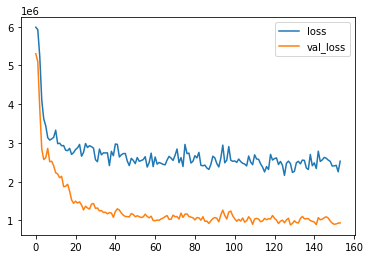

In [57]:
# Create the X and y variables
# X should contain everything except for the sales and salesQuartile columns
X = df_nn.drop(['salesRounded'], axis=1).values
y = df_nn['salesRounded'].values

# Partition the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Create the scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Scale the X variables
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create the neural network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

n_units = X_train.shape[1]
_epochs = 600

# Create the neural network. Output should be integer from 1-# of sales quartiles
nn = Sequential()
nn.add(Dense(n_units, activation='relu'))
nn.add(Dropout(0.5))
nn.add(Dense(n_units, activation='relu'))
nn.add(Dropout(0.5))
nn.add(Dense(n_units, activation='relu'))
nn.add(Dropout(0.5))
nn.add(Dense(1, activation='linear'))

# Compile the neural network
nn.compile(optimizer='adam', loss='mse')

# Create the early stopping callback
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

# Fit the neural network
nn.fit(x=X_train, y=y_train, epochs=_epochs, validation_data=(X_test, y_test), callbacks=[early_stop])

# Get the loss
losses = pd.DataFrame(nn.history.history)
losses.plot()

# Make predictions
y_pred = nn.predict(X_test)

# Calculate the accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred.round())
print(f'Accuracy: {accuracy}')

In [58]:
# Get Mean Absolute Error
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 614.175485598878


In [59]:
# Create a dataframe with the actual sales and the predicted sales
df_results = pd.DataFrame({'Actual Sales': y_test, 'Predicted Sales': y_pred.flatten()})
df_results

,Actual Sales,Predicted Sales
0,3000,1716.544922
1,1000,927.151123
2,600,556.910522
3,300,556.910522
4,2000,1194.109375
...,...,...
2994,600,556.910522
2995,600,556.910522
2996,1000,721.347107
2997,300,556.910522


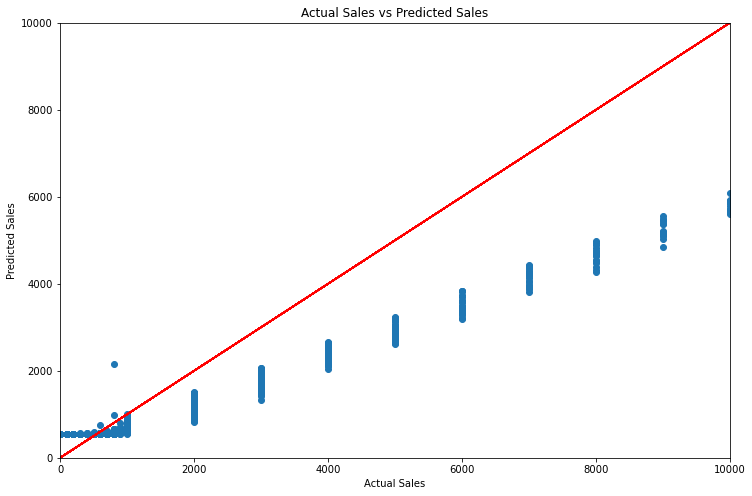

In [60]:
# Create a scatter plot of the actual sales and the predicted sales. The axes limits should be 10000 and plot a line for the actual sales vs actual sales.
plt.figure(figsize=(12, 8))
plt.scatter(x=df_results['Actual Sales'], y=df_results['Predicted Sales'])
plt.plot(df_results['Actual Sales'], df_results['Actual Sales'], color='red')
plt.xlim(0, 10000)
plt.ylim(0, 10000)
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Actual Sales vs Predicted Sales')
plt.show()

## Analyzing Results

In [61]:
# find the slope of the line of best fit to the actual sales vs predicted sales
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(df_results['Actual Sales'], df_results['Predicted Sales'])
print(f'Slope: {slope}')
print(f'Intercept: {intercept}')
print(f'R^2 Value: {r_value**2}')

Slope: 0.5243879538782208
Intercept: 251.79299640041745
R^2 Value: 0.9669505786017953


## Assessing Feature Importance

In [62]:
# Create a dataframe with the feature names and their importance
df_importance = pd.DataFrame({'Feature': df_nn.drop(['sales'], axis=1).columns, 'Importance': abs(nn.layers[0].get_weights()[0].mean(axis=1))})
df_importance

,Feature,Importance
0,numberOfSellers,0.009136
1,isVariation,0.011411
2,price,1.657079
3,numberOfItems,0.539096
4,salesRounded,0.013848
5,predictedSalesFromTitle,0.097165
